#### NOTE ABOUT THE PSD CALCULATIONS
Throwing away steps 4, 5 from each optic because they have a strange defocus component.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
#load modules
import numpy as np
np.set_printoptions(suppress=True) # scientific notation gets annoying
import matplotlib.pyplot as plt
import matplotlib
from astropy import units as u
from astropy.io import fits
from mpl_toolkits.axes_grid1 import make_axes_locatable
import scipy.ndimage

# draw the dark hole regions
from skimage.draw import draw

# PSD code
import h5py
import copy

# import personal code
from model_kit import psd_functions as psd
from model_kit import datafiles as dfx
from model_kit import zernike as zern
from model_kit import dust
import poppy

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

from datetime import datetime
date_ran = datetime.now()
dr_str = date_ran.strftime("%d/%m/%Y %H:%M:%S")
print('Last date this notebook has been ran: {0}'.format(dr_str))

Last date this notebook has been ran: 20/09/2021 17:25:24


In [2]:
# initialize the data
tot_fm = 1
tot_step= 4 # the last 2 step sets are bad news 
fits_folder = 'flat_mirrors/fixed_fits/'
raw_folder = 'flat_mirrors/2018_03_23/'

opt_parms = {'ca' : 80, # of the 80% CA given
             'ovs': 4096,
             'diam_100CA': 0.0125*u.m, #12.5*u.mm,
             'label': '0p5in',
             'surf_units': u.micron,
             'ring_width': 5,
             'kmid_ll': 100/u.m, #0.1/u.mm,
             'khigh_ll': 1000/u.m} #1/u.mm}

# import the zernike difference produced by glue
import pickle
filename='/home/jhen/XWCL/code/MagAOX/PSD/zygo_data/zern_glue_diff.pickle'
objects = []
with (open(filename, "rb")) as openfile:
    while True:
        try:
            objects.append(pickle.load(openfile))
        except EOFError:
            break
zern_glue_diff = objects[0]['zern_glue_diff']

# load the unglued surfaces and dust masks
nt_ptt = 3
for nf in range(0, tot_fm):
    fm_num = nf+1
    for ns in range(0, tot_step):
        surf_name = 'flat_{0}_n{1}_{2}CA_step{3}'.format(opt_parms['label'], nf+1,
                                                         opt_parms['ca'], ns)
        mask = fits.open(fits_folder+surf_name+'_bigdust_mask.fits')[0].data
        surf_fits = fits.open(fits_folder+surf_name+'_z{0}_surf.fits'.format(nt_ptt))[0]
        surf_data = surf_fits.data * mask
        surf_hdr = surf_fits.header
        
        if ns==0 and nf==0:
            opt_parms['wavelen'] = surf_hdr['wavelen'] * u.m
            opt_parms['latres'] = surf_hdr['latres'] * u.m
            opt_parms['diam_ca'] = surf_hdr['diam_ca'] * u.m
            data_set = np.zeros((tot_fm, tot_step, mask.shape[0], mask.shape[0]))
            dust_set = np.zeros((tot_fm, tot_step, mask.shape[0], mask.shape[0]))
        
        data_set[nf][ns] = surf_data
        dust_set[nf][ns] = mask
data_set = data_set * opt_parms['surf_units']

In [3]:
# Apply the glue zernikes, save as .FITS to evalulate with L-S
nt_glue = 11
glue_surf = np.zeros_like(dust_set)
for nf in range(0, tot_fm): # choose optic
    for ns in range(0, tot_step):
        dust_mask = dust_set[nf][ns]
        test_surf = data_set[nf][ns]
        # build the Zernikes using the arbitrary basis for mask holes
        zm = poppy.zernike.arbitrary_basis(aperture=dust_mask, nterms=nt_glue, outside=0.0)

        # change surface units from microns to radians
        data_surf = test_surf/(opt_parms['wavelen'].to(test_surf.unit)/(2*np.pi*u.radian))
            
        # Apply the average glue Zernike values
        for j in range(3, nt_glue): # skip PTT
            data_surf = (data_surf + (zern_glue_diff[j]*zm[j]*u.rad)) * dust_mask

        # convert back to surface units
        final_surf = (data_surf * (opt_parms['wavelen'].to(test_surf.unit)/(2*np.pi*u.radian))).value
        
        # write to file
        glue_surf[nf][ns] = final_surf
        
        header = fits.Header()
        header['wavelen'] = (opt_parms['wavelen'].value,
                             'Zygo wavelength [{0}]'.format(opt_parms['wavelen'].unit))
        header['latres'] = (opt_parms['latres'].value,
                            'Lateral resolution [{0}]'.format(opt_parms['latres'].unit))
        header['surfunit'] = (str(test_surf.unit),
                              'Surface Units')
        header['diam_100'] = (opt_parms['diam_100CA'].value,
                              'Full optic diameter at 100% CA [{0}]'.format(opt_parms['diam_100CA'].unit))
        header['diam_ca'] = (opt_parms['diam_ca'].value, 
                             'Data diameter at clear aperture [{0}]'.format(opt_parms['diam_ca'].unit))
        header['clear_ap'] = (opt_parms['ca'], 
                              'Clear aperture [percent]')
        surf_name = 'flat_{0}_n{1}_{2}CA_step{3}'.format(opt_parms['label'], nf+1,
                                                         opt_parms['ca'], ns)
        #fits.writeto(fits_folder+surf_name+'_bigdust_mask.fits', dust_mask, header, overwrite=True)
        header['COMMENT'] = 'Surface has PTT Zernikes removed with dust not regarded'
        header['COMMENT'] = 'Glue zernike aberrations have been applied for n=4:11 (Noll)'
        #fits.writeto(fits_folder+surf_name+'_glue_surf.fits', final_surf, header, overwrite=True)

glue_surf = glue_surf * test_surf.unit

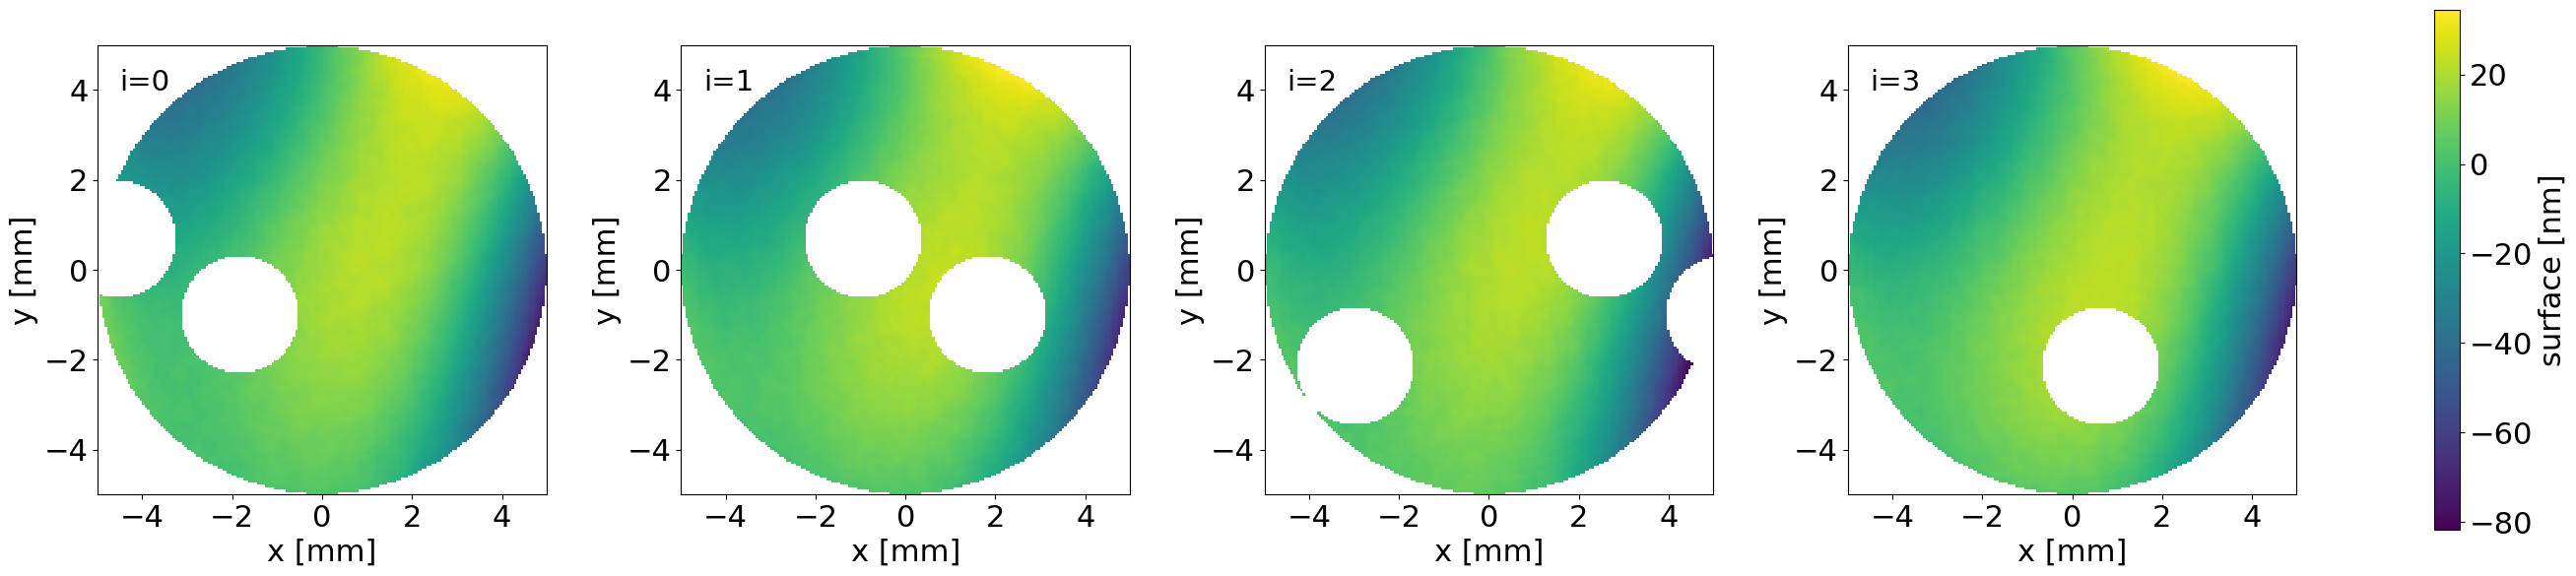

In [4]:
# generating the WFE data for the paper, do not delete please

# pick the data set
nf = 0
data_set = glue_surf[nf].to(u.nm)
vmin = np.amin(data_set.value)
vmax = np.amax(data_set.value)

# set the axis scaling
rks = dfx.calc_axis(data_set.shape[1], (opt_parms['latres'].to(u.mm)))
rks_extent = [np.amin(rks).value, np.amax(rks).value, 
              np.amin(rks).value, np.amax(rks).value]

matplotlib.rcParams["font.size"]=22
fig, axes = plt.subplots(nrows=1, ncols=4, dpi=100, figsize=(36,7), facecolor='white')#, dpi=100)
fig.subplots_adjust(wspace=0.3)

n=0
for ax in axes.flat:
    sn_data = dfx.sn_map(data_set[n].value, dust_set[nf][n])
    #sn_data = data_set[n].value
    im = ax.imshow(sn_data, origin='lower',
                   extent=rks_extent, vmin=vmin, vmax=vmax)
    ax.set_xticks([-4, -2, 0, 2, 4])
    ax.set_yticks([-4, -2, 0, 2, 4])
    ax.set_xlabel('x [{0}]'.format(str(rks.unit)))
    ax.set_ylabel('y [{0}]'.format(str(rks.unit)))
    step_name = 'i={0}'.format(n)
    ax.text(-4.5, 4, step_name, fontsize=21, color='black')
    n += 1
    
fig.colorbar(im, ax=axes.ravel().tolist()).set_label('surface [{0}]'.format(str(data_set.unit)))
plt.show()

In [5]:
def rms(data):
    return np.sqrt(np.sum(np.square(data))/len(data-np.mean(data)))

rms_set = np.zeros((tot_step))
for i in range(0, tot_step):
    rms_set[i] = rms(data_set[i][dust_set[0][i]==1]).value
(np.mean(rms_set), np.std(rms_set))

(18.792403485852866, 0.21851841575287492)